<h1 align="center">Customer Segmentation Using RFM and K-NN</h1>

_____

<b>RFM</b> (Recency, Frequency, and Monetary) is a customer segmentation model that helps businesses identify their most valuable customers by analyzing their transactional behavior. The model is based on three key metrics: Recency, which measures the time since a customer's last purchase; Frequency, which represents the total number of purchases made by a customer; and Monetary, which quantifies the total revenue generated by a customer. By categorizing customers into different segments based on their RFM values, businesses can tailor their marketing and customer engagement strategies to target specific customer groups more effectively.
This approach enables companies to allocate their resources efficiently, improve customer retention, and maximize revenue growth by focusing on high-value customer segments, such as loyal customers and potential loyalists, while also identifying customers who are at risk of churn or require re-engagement efforts.

<h3>Data Source:</h3>

<a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail+II">UCI Online Retail II Data Set</a>

In [1]:
# Importing necessary libraries

import squarify
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta


<h3>Data Preparation:</h3>

In [2]:
# Importing the data

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_ = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [5]:
# Removing observations with null values

df.dropna(inplace=True)

In [6]:
df["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
Name: Description, dtype: int64

In [7]:
df["Description"].nunique()

3896

In [8]:
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False).head()

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53215
JUMBO BAG RED RETROSPOT,45066
ASSORTED COLOUR BIRD ORNAMENT,35314
WHITE HANGING HEART T-LIGHT HOLDER,34147
PACK OF 72 RETROSPOT CAKE CASES,33409


In [9]:
df["Invoice"].nunique()

22190

In [10]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [11]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [12]:
df.describe([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Quantity,397925.00000,13.02179,180.41998,1.00000,1.00000,1.00000,1.00000,2.00000,6.00000,12.00000,24.00000,36.00000,120.00000,80995.00000
Price,397925.00000,3.11621,22.09677,0.00000,0.21000,0.42000,0.55000,1.25000,1.95000,3.75000,6.35000,8.50000,14.95000,8142.75000
Customer ID,397925.00000,15294.30860,1713.17274,12346.00000,12415.00000,12627.00000,12883.00000,13969.00000,15159.00000,16795.00000,17725.00000,17912.00000,18211.00000,18287.00000
TotalPrice,397925.00000,22.39474,309.05520,0.00000,0.55000,1.25000,1.95000,4.68000,11.80000,19.80000,35.40000,67.50000,202.50000,168469.60000


In [13]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

We defined a variable called today_date to calculate the Recency value. We made this variable two days more than the last date in the data. The purpose of doing this was to prevent the Recency value of those who shopped on the last date in the dataset from being 0.

In [14]:
today_date = dt.datetime(2011, 12, 11)

<h3> RFM Model:</h3>

In [15]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: len(num),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [16]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [17]:
rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

We divided the Recency value into segments. A high Recency value indicates that the customer is moving away from us. To prevent this confusion, we labeled them in a descending order.

In [18]:
rfm["RecencyScore"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["FrequencyScore"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5])
rfm["MonetaryScore"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

In [19]:
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) +
                    rfm['FrequencyScore'].astype(str) +
                    rfm['MonetaryScore'].astype(str))

We defined a variable called RFM_SCORE to see the RFM value in a single point

In [20]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal',
    r'41': 'Promising',
    r'51': 'New',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'
}

We assigned segments corresponding to the RFM values using regex

In [21]:
rfm["Segment"] = (rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str))
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)

In [22]:
# We grouped the RFM values by segments and took the average and count of their values.

rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])

Recency       Frequency         Monetary      
                         mean count      mean count       mean count
Segment                                                             
About_to_Sleep       53.19255   322  15.98758   322  450.99717   322
At_Risk             166.43585   569  56.85940   569  996.91687   569
Cant_Loose          144.22619    84 181.66667    84 2370.70501    84
Champions             6.40099   606 289.03135   606 6960.91545   606
Hibernating         210.25140  1074  13.58939  1074  536.53567  1074
Loyal                34.20685   817 157.11628   817 2845.73285   817
Need_Attention       52.98537   205  41.73659   205  856.19585   205
New                   7.42105    57   7.57895    57 3618.69702    57
Potential_Loyalists  16.66870   492  34.94512   492  915.48699   492
Promising            23.43750   112   7.76786   112  429.43393   112

In [23]:
# We took the values of the people in the Loyal_Customers segment and exported them as a CSV file.

rfm[rfm["Segment"] == "Loyal_Customers"].index


Float64Index([], dtype='float64', name='Customer ID')

In [24]:
new_df = pd.DataFrame()
new_df["Loyal_Customers"] = rfm[rfm["Segment"] == "Loyal_Customers"].index
new_df.to_csv("Loyal_Customers.csv")

In [25]:
rfm

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346.00000,326,1,77183.60000,1,1,5,115,Hibernating
12347.00000,3,182,4310.00000,5,5,5,555,Champions
12348.00000,76,31,1797.24000,2,3,4,234,At_Risk
12349.00000,19,73,1757.55000,4,4,4,444,Loyal
12350.00000,311,17,334.40000,1,2,2,122,Hibernating
...,...,...,...,...,...,...,...,...
18280.00000,278,10,180.60000,1,1,1,111,Hibernating
18281.00000,181,7,80.82000,1,1,1,111,Hibernating
18282.00000,8,12,178.05000,5,1,1,511,New


In [26]:
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346.00000,326,1,77183.60000,1,1,5,115,Hibernating
12347.00000,3,182,4310.00000,5,5,5,555,Champions
12348.00000,76,31,1797.24000,2,3,4,234,At_Risk
12349.00000,19,73,1757.55000,4,4,4,444,Loyal
12350.00000,311,17,334.40000,1,2,2,122,Hibernating


<h3> Visualization:</h3>

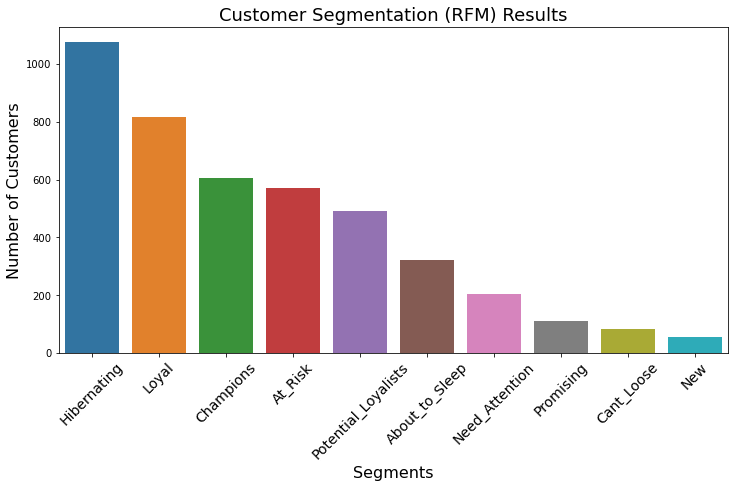

In [27]:

# Count the number of customers in each segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Plot the number of customers in each segment using a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='Count', data=segment_counts)
plt.title('Customer Segmentation (RFM) Results', size =18)
plt.xlabel('Segments', size = 16)
plt.ylabel('Number of Customers', size = 16)
plt.xticks(rotation=45, size = 14)
plt.show()


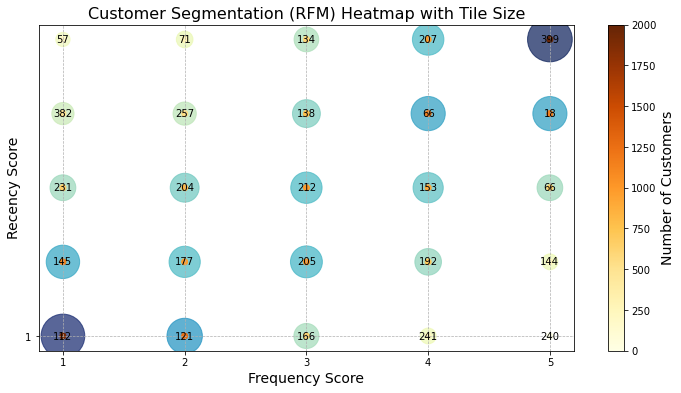

In [28]:

# Create a pivot table with RecencyScore and FrequencyScore as indices, and count of customers in each cell
rfm_pivot = rfm.pivot_table(index='RecencyScore', columns='FrequencyScore', values='Segment', aggfunc='count', fill_value=0)

# Normalize the count of customers in each cell to be between 0 and 1 for sizing
normalized_rfm_pivot = (rfm_pivot - rfm_pivot.min().min()) / (rfm_pivot.max().max() - rfm_pivot.min().min())

# Prepare data for scatterplot
X, Y = np.meshgrid(rfm_pivot.columns, rfm_pivot.index)
sizes = normalized_rfm_pivot.values.flatten() * 2000  # Scale size for better visibility

# Create the scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(X, Y, s=sizes, c=sizes, cmap='YlGnBu', alpha=0.7)

# Add annotations for the count of customers in each cell
for i, row in enumerate(rfm_pivot.index):
    for j, col in enumerate(rfm_pivot.columns):
        plt.text(col, row, int(rfm_pivot.loc[row, col]), ha='center', va='center', color='black')

plt.title('Customer Segmentation (RFM) Heatmap with Tile Size', size = 16)
plt.xlabel('Frequency Score', size =14)
plt.ylabel('Recency Score', size =14)
plt.xticks(np.arange(1, rfm_pivot.columns.max() + 1))
plt.yticks(np.arange(1, rfm_pivot.index.max() + 1))
plt.colorbar(plt.scatter(X, Y, c=sizes, cmap='YlOrBr')).set_label('Number of Customers', size = 14)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.show()


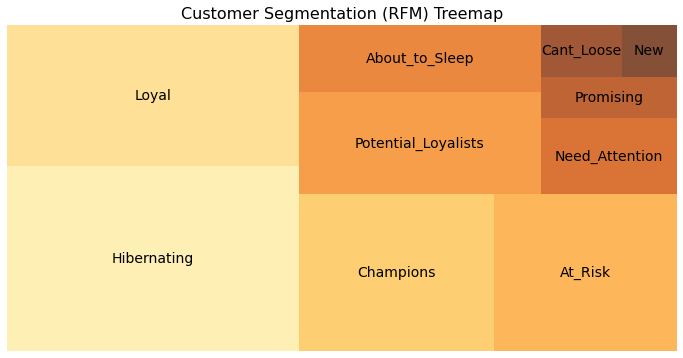

In [29]:

# Count the number of customers in each segment
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Prepare data for treemap
labels = segment_counts['Segment']
sizes = segment_counts['Count']
colors = plt.cm.YlOrBr(np.linspace(0.2, 1, len(labels)))

# Create the treemap using Squarify
plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 14})
plt.title('Customer Segmentation (RFM) Treemap', size= 16)
plt.axis('off')
plt.show()


<h3> K-NN Clustering:</h3>

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


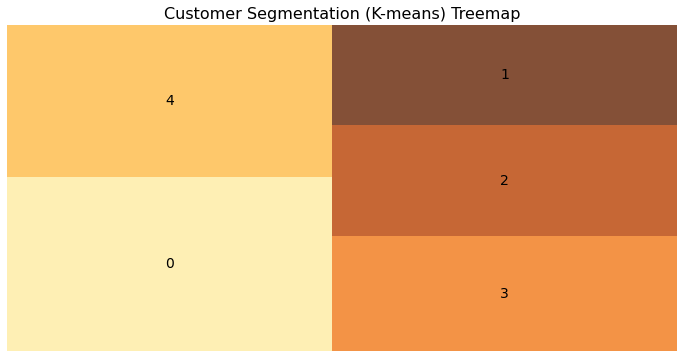

In [30]:

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate RFM values
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalPrice': 'sum'
})

# Rename the columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

# Normalize the RFM data using log transformation
rfm_log = np.log(rfm + 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_log)

# Count the number of customers in each cluster
cluster_counts = rfm['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

# Prepare data for treemap
labels = cluster_counts['Cluster'].astype(str)
sizes = cluster_counts['Count']
colors = plt.cm.YlOrBr(np.linspace(0.2, 1, len(labels)))

# Create the treemap using Squarify
plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 14})
plt.title('Customer Segmentation (K-means) Treemap', size=16)
plt.axis('off')
plt.show()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


          Recency Frequency   Monetary      
             mean      mean       mean count
Cluster                                     
0       164.60000  34.00000  653.70000  1124
1         9.00000 312.00000 8142.50000   687
2       183.60000   8.30000  194.90000   761
3        18.60000  35.90000  586.10000   785
4        56.90000 112.90000 2010.60000   982


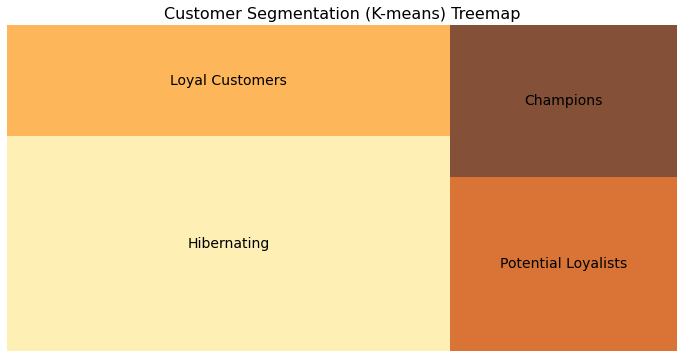

In [31]:

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate RFM values
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'TotalPrice': 'sum'
})

# Rename the columns
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

# Normalize the RFM data using log transformation
rfm_log = np.log(rfm + 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_log)

# Calculate cluster statistics
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_stats)

# Get cluster centroids
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])

# Transform the centroids back to the original scale
cluster_centroids = np.exp(cluster_centroids) - 1
def assign_label(row):
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    
    if recency >= 130 and frequency < 30 and monetary < 500:
        return 'Hibernating'
    elif recency <= 10 and frequency > 200 and monetary > 4000:
        return 'Champions'
    elif recency >= 130 and frequency < 10 and monetary < 200:
        return 'At Risk'
    elif recency <= 20 and frequency < 30 and monetary < 500:
        return 'Potential Loyalists'
    else:
        return 'Loyal Customers'

cluster_labels = cluster_centroids.apply(assign_label, axis=1)
rfm['Label'] = rfm['Cluster'].map(cluster_labels)

# Count the number of customers in each segment
segment_counts = rfm['Label'].value_counts().reset_index()
segment_counts.columns = ['Label', 'Count']

# Prepare data for treemap
labels = segment_counts['Label']
sizes = segment_counts['Count']
colors = plt.cm.YlOrBr(np.linspace(0.2, 1, len(labels)))

# Create the treemap using Squarify
plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 14})
plt.title('Customer Segmentation (K-means) Treemap', size=16)
plt.axis('off')
plt.show()


In [32]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalPrice'],
      dtype='object')

In [33]:
rfm["Label"].unique()

array(['Hibernating', 'Champions', 'Loyal Customers',
       'Potential Loyalists'], dtype=object)

In [34]:
print(cluster_centroids)

    Recency  Frequency   Monetary
0 138.92431   28.96783  497.01645
1   6.39975  215.28935 4092.83333
2 143.08699    6.74741  155.75275
3  14.40375   28.21954  456.47111
4  44.95491   96.12751 1617.21438
